In [ ]:
! pip install transformers==4.52.1 rouge-score nltk
!pip install -U datasets evaluate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Transformers/Project_T5/GQA_with_grouping')

In [ ]:
from datasets import load_dataset
from evaluate import load

raw_datasets = load_dataset("cnn_dailymail", "3.0.0")
metric = load("rouge")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [ ]:
raw_datasets["train"] = raw_datasets["train"].shuffle(seed=42).select(range(20000))
raw_datasets["validation"] = raw_datasets["validation"].shuffle(seed=42).select(range(2000))
raw_datasets["test"] = raw_datasets["test"].shuffle(seed=42).select(range(2000))

In [ ]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 2000
    })
})

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "google/t5-v1_1-small"
fp16_problem = False

if model_checkpoint.startswith("google/t5-v1_1"):
  fp16_problem = True
  print("This model has a problem with fp16, we will apply a fix later on.")

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

This model has a problem with fp16, we will apply a fix later on.


tokenizer_config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
max_input_length = 1024
max_target_length = 128
prefix = "summarize: "

def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["article"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    labels = tokenizer(text_target=examples["highlights"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
from transformers import TrainerCallback
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions.tolist(), skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels.tolist(), skip_special_tokens=True)

    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True, use_aggregator=True)
    result = {key: value * 100 for key, value in result.items()}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}


class PlotLossAccuracyCallback(TrainerCallback):
    def __init__(self):
        self.train_loss = []
        self.eval_loss = []
        self.eval_acc = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None:
            return

        print(f"[LOG] Step {state.global_step}: {logs}")

        if "loss" in logs:
            self.train_loss.append((state.global_step, logs["loss"]))
        if "eval_loss" in logs:
            self.eval_loss.append((state.global_step, logs["eval_loss"]))
        if "eval_accuracy" in logs:
            self.eval_acc.append((state.global_step, logs["eval_accuracy"]))

    def plot(self):
      steps_train, loss_train = zip(*self.train_loss) if self.train_loss else ([], [])
      steps_eval, loss_eval = zip(*self.eval_loss) if self.eval_loss else ([], [])
      steps_acc, acc_eval = zip(*self.eval_acc) if self.eval_acc else ([], [])

      plt.figure(figsize=(12, 5))

      if loss_train or loss_eval:
          plt.subplot(1, 2, 1)
          if loss_train:
              plt.plot(steps_train, loss_train, label="Train Loss")
          if loss_eval:
              plt.plot(steps_eval, loss_eval, label="Eval Loss")
          plt.xlabel("Step")
          plt.ylabel("Loss")
          plt.title("Training and Eval Loss")
          plt.legend()

      if acc_eval:
          plt.subplot(1, 2, 2)
          plt.plot(steps_acc, acc_eval, label="Eval Accuracy", color="green")
          plt.xlabel("Step")
          plt.ylabel("Accuracy")
          plt.title("Validation Accuracy")
          plt.legend()

    plt.tight_layout()
    plt.savefig("loss_accuracy_plot.png")
    plt.show()


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


<Figure size 640x480 with 0 Axes>

# **Problem with fp16 fix**

In [ ]:
import torch
from transformers.models.t5.modeling_t5 import T5LayerFF

def _forward(self, hidden_states):
        forwarded_states = self.layer_norm(hidden_states)
        forwarded_states = self.DenseReluDense(forwarded_states)
        hidden_states = hidden_states + self.dropout(forwarded_states)
        return hidden_states

def safe_t5_ff_forward(self, hidden_states):
    # many t5/mt5 models are trained in bfloat16 and don't do well under mixed precision (fp16).
    # It appears that it's enough to disable autocast for this FF layer to avoid inf/nan
    # problems for the whole model
    if torch.is_autocast_enabled():
        with torch.cuda.amp.autocast(enabled=False):
            return self._forward(hidden_states)
    else:
        return self._forward(hidden_states)

if fp16_problem:
  print(f"Patching T5LayerFF.forward for {model_checkpoint} to disable AMP in FF layer")
  T5LayerFF._forward = _forward
  T5LayerFF.forward = safe_t5_ff_forward

Patching T5LayerFF.forward for google/t5-v1_1-small to disable AMP in FF layer


# **Training loop**

In [ ]:
grouping_list_close_attention = [[0, 1, 2, 1, 0, 2],
                 [0, 1, 2, 1, 0, 2],
                 [0, 0, 2, 1, 1, 2],
                 [0, 0, 1, 1, 2, 2],
                 [0, 1, 1, 2, 2, 0],
                 [0, 1, 0, 1, 2, 2],
                 [0, 1, 0, 2, 1, 2],
                 [0, 1, 2, 1, 0, 2],
                 [0, 1, 0, 1, 2, 2],
                 [0, 1, 0, 2, 1, 2],
                 [0, 1, 2, 1, 0, 2],
                 [0, 1, 2, 1, 2, 0],
                 [0, 1, 2, 1, 0, 2],
                 [0, 1, 2, 0, 1, 2],
                 [0, 1, 2, 2, 1, 0],
                 [0, 1, 2, 1, 0, 2]]

grouping_list_standard = [[0, 0, 1, 1, 2, 2],
                 [0, 0, 1, 1, 2, 2],
                 [0, 0, 1, 1, 2, 2],
                 [0, 0, 1, 1, 2, 2],
                 [0, 0, 1, 1, 2, 2],
                 [0, 0, 1, 1, 2, 2],
                 [0, 0, 1, 1, 2, 2],
                 [0, 0, 1, 1, 2, 2],
                 [0, 0, 1, 1, 2, 2],
                 [0, 0, 1, 1, 2, 2],
                 [0, 0, 1, 1, 2, 2],
                 [0, 0, 1, 1, 2, 2],
                 [0, 0, 1, 1, 2, 2],
                 [0, 0, 1, 1, 2, 2],
                 [0, 0, 1, 1, 2, 2],
                 [0, 0, 1, 1, 2, 2]]


grouping_list_far_attention = [[0, 2, 1, 1, 0, 2],
                 [0, 1, 0, 1, 2, 2],
                 [0, 1, 1, 2, 0, 2],
                 [0, 1, 0, 2, 1, 2],
                 [0, 1, 0, 1, 2, 2],
                 [0, 1, 0, 1, 2, 2],
                 [0, 0, 1, 1, 2, 2],
                 [0, 1, 0, 1, 2, 2],
                 [0, 0, 1, 1, 2, 2],
                 [0, 2, 1, 1, 2, 0],
                 [0, 0, 1, 1, 2, 2],
                 [0, 1, 0, 1, 2, 2],
                 [0, 0, 1, 1, 2, 2],
                 [0, 1, 2, 2, 1, 0],
                 [0, 0, 1, 1, 2, 2],
                 [0, 1, 0, 1, 2, 2]]

assert len(grouping_list_far_attention) == 16

grouping by:  [[0, 0, 1, 1, 2, 2], [0, 0, 1, 1, 2, 2], [0, 0, 1, 1, 2, 2], [0, 0, 1, 1, 2, 2], [0, 0, 1, 1, 2, 2], [0, 0, 1, 1, 2, 2], [0, 0, 1, 1, 2, 2], [0, 0, 1, 1, 2, 2], [0, 0, 1, 1, 2, 2], [0, 0, 1, 1, 2, 2], [0, 0, 1, 1, 2, 2], [0, 0, 1, 1, 2, 2], [0, 0, 1, 1, 2, 2], [0, 0, 1, 1, 2, 2], [0, 0, 1, 1, 2, 2], [0, 0, 1, 1, 2, 2]]


/tmp/ipython-input-21-436077963.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,3.446000,2.511109,21.654900,7.897700,16.415800,20.181700,19.986500
2,3.232700,2.438816,21.700800,7.903900,16.550500,20.205000,19.996500


[LOG] Step 150: {'loss': 6.5692, 'grad_norm': 3.176027297973633, 'learning_rate': 9.702e-05, 'epoch': 0.06}
[LOG] Step 300: {'loss': 4.9583, 'grad_norm': 3.7313766479492188, 'learning_rate': 9.402000000000001e-05, 'epoch': 0.12}
[LOG] Step 450: {'loss': 4.5318, 'grad_norm': 3.075669765472412, 'learning_rate': 9.102e-05, 'epoch': 0.18}
[LOG] Step 600: {'loss': 4.2672, 'grad_norm': 3.9639856815338135, 'learning_rate': 8.802e-05, 'epoch': 0.24}
[LOG] Step 750: {'loss': 4.131, 'grad_norm': 3.312220811843872, 'learning_rate': 8.502e-05, 'epoch': 0.3}
[LOG] Step 900: {'loss': 4.0083, 'grad_norm': 3.7635040283203125, 'learning_rate': 8.202e-05, 'epoch': 0.36}
[LOG] Step 1050: {'loss': 3.8899, 'grad_norm': 3.3760225772857666, 'learning_rate': 7.902e-05, 'epoch': 0.42}
[LOG] Step 1200: {'loss': 3.8178, 'grad_norm': 3.4070565700531006, 'learning_rate': 7.602000000000001e-05, 'epoch': 0.48}
[LOG] Step 1350: {'loss': 3.7444, 'grad_norm': 3.187465190887451, 'learning_rate': 7.302e-05, 'epoch': 0.54

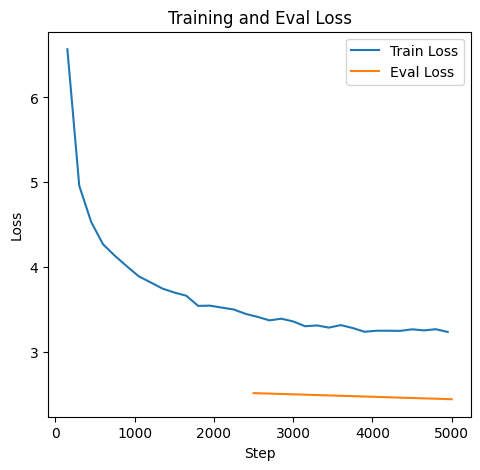

In [ ]:
from Init_T5_to_GQA import convert_t5_to_gqa
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

print("grouping by: ", grouping_list_standard)

kv_list = [3]
for kv_heads in kv_list:
  model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
  convert_t5_to_gqa(model.decoder, kv_heads=kv_heads, heads_grouping_arr=grouping_list_standard, inplace=True)

  batch_size = 8
  args = Seq2SeqTrainingArguments(
      output_dir=f"/content/drive/MyDrive/technion/Trasformers/Project_T5/GQA_with_grouping/fine_tune_CNN_DailyMail_{kv_heads}",
      eval_strategy = "epoch",
      save_strategy="epoch",
      learning_rate=1e-4,
      per_device_train_batch_size=batch_size,
      per_device_eval_batch_size=batch_size,
      weight_decay=0.01,
      save_total_limit=1,
      num_train_epochs=2,
      logging_dir="/content/drive/MyDrive/technion/Trasformers/Project_T5/logs",
      logging_steps=150,
      predict_with_generate=True,
      report_to="none"
  )

  data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

  plot_callback = PlotLossAccuracyCallback()

  trainer = Seq2SeqTrainer(
      model,
      args,
      train_dataset=tokenized_datasets["train"],
      eval_dataset=tokenized_datasets["validation"],
      data_collator=data_collator,
      tokenizer=tokenizer,
      compute_metrics=compute_metrics,
      callbacks=[plot_callback]
  )

  trainer.train()
  plot_callback.plot()

In [ ]:
test_results = trainer.predict(tokenized_datasets["test"])

# Print ROUGE-1 (and optionally others)
print("Test set ROUGE scores:")
print(f"ROUGE-1: {test_results.metrics['test_rouge1']:.2f}")